**<font size='6' color='aqua'>ch4. RNN(Recurrent Neural Network 순환신경망)</font>**
# 1. 문맥을 이용하여 모델만들기 - 전처리

In [56]:
from keras_preprocessing.text import Tokenizer # text 를 숫자로 바꾸는 함수
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential # 순차적 레이어 모델 생성
from tensorflow.keras.layers import Embedding, SimpleRNN # 희소행렬 변환, RNN
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

In [3]:
text = """경마장에 있는 말이 뛰고 있다
그의말이 법이다
가는 말이 고와야 오는 말이 곱다"""

In [15]:
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]
print(encoded)
print(t.word_index)

[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [7]:
# 문자열을 인덱스 시퀀스로 반환
print(t.texts_to_sequences(['경마장에 말이 있다', '말이 곱다 ']))
print(t.texts_to_sequences(['경마장에 말이 있다'])[0])

[[2, 1, 5], [1, 11]]
[2, 1, 5]


In [9]:
print(t.texts_to_matrix(['말이 뛰고']))
print(t.texts_to_sequences(['말이 뛰고']))

[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[1, 4]]


In [13]:
text = """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""

In [20]:
print(t.word_index)
for word, value in t.word_index.items():
    if value==2:
        print("2:", word)
        break

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}
2: 경마장에


In [24]:
# text 를 학습시키기 위해 ['경마장에 있는', '경마장에 있는 말이', '경마장에 있는 말이 뛰고', '경마장에 있는 말이 뛰고']
sequences = []
for line in text.split('\n'):
    print('원래 문장 :', line)
    encoded = t.texts_to_sequences([line])[0]
    print('encoded 문장 :', encoded)
    for i in range(0, len(encoded)-1): # 시작 index 
        for j in range(i+2, len(encoded)+1): # 끝나는 index
            sequences.append(encoded[i:j])
# sequences
print('sequences와 해석을 출력')
for sequence in sequences:
    print('[', end='')
    for word_seq in sequence:
        for word, value in t.word_index.items():
            if word_seq==value:
                print("{}:{}".format(word_seq, word), end='')
                break
    print(']')

원래 문장 : 경마장에 있는 말이 뛰고 있다
encoded 문장 : [2, 3, 1, 4, 5]
원래 문장 : 그의 말이 법이다
encoded 문장 : [6, 1, 7]
원래 문장 : 가는 말이 고와야 오는 말이 곱다
encoded 문장 : [8, 1, 9, 10, 1, 11]
sequences와 해석을 출력
[2:경마장에3:있는]
[2:경마장에3:있는1:말이]
[2:경마장에3:있는1:말이4:뛰고]
[2:경마장에3:있는1:말이4:뛰고5:있다]
[3:있는1:말이]
[3:있는1:말이4:뛰고]
[3:있는1:말이4:뛰고5:있다]
[1:말이4:뛰고]
[1:말이4:뛰고5:있다]
[4:뛰고5:있다]
[6:그의1:말이]
[6:그의1:말이7:법이다]
[1:말이7:법이다]
[8:가는1:말이]
[8:가는1:말이9:고와야]
[8:가는1:말이9:고와야10:오는]
[8:가는1:말이9:고와야10:오는1:말이]
[8:가는1:말이9:고와야10:오는1:말이11:곱다]
[1:말이9:고와야]
[1:말이9:고와야10:오는]
[1:말이9:고와야10:오는1:말이]
[1:말이9:고와야10:오는1:말이11:곱다]
[9:고와야10:오는]
[9:고와야10:오는1:말이]
[9:고와야10:오는1:말이11:곱다]
[10:오는1:말이]
[10:오는1:말이11:곱다]
[1:말이11:곱다]


In [25]:
sequences[:5]

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [3, 1]]

In [26]:
# sequence 별 len
print([len(sequence) for sequence in sequences])

[2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2]


In [27]:
my_len = max([len(sequence) for sequence in sequences])
my_len

6

In [35]:
# sequences 를 훈련 가능하도록 6개열로 조정
padded_sequences = pad_sequences(sequences=sequences,
                                maxlen=my_len, # 최대 열수
                                padding='pre', # 최대 열수보다 작은 경우 0을 채울 위치
                                #padding='post'
                                #value=1,
                                #truncating='pre', #최대 열수보다 많은 경우 데이터를 짜를 위치
                                )
type(padded_sequence), padded_sequence.shape, padded_sequence

(numpy.ndarray,
 (28, 6),
 array([[ 0,  0,  0,  0,  2,  3],
        [ 0,  0,  0,  2,  3,  1],
        [ 0,  0,  2,  3,  1,  4],
        [ 0,  2,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  3,  1,  4],
        [ 0,  0,  3,  1,  4,  5],
        [ 0,  0,  0,  0,  1,  4],
        [ 0,  0,  0,  1,  4,  5],
        [ 0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  6,  1],
        [ 0,  0,  0,  6,  1,  7],
        [ 0,  0,  0,  0,  1,  7],
        [ 0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  8,  1,  9],
        [ 0,  0,  8,  1,  9, 10],
        [ 0,  8,  1,  9, 10,  1],
        [ 8,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  1,  9],
        [ 0,  0,  0,  1,  9, 10],
        [ 0,  0,  1,  9, 10,  1],
        [ 0,  1,  9, 10,  1, 11],
        [ 0,  0,  0,  0,  9, 10],
        [ 0,  0,  0,  9, 10,  1],
        [ 0,  0,  9, 10,  1, 11],
        [ 0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 10,  1, 11],
        [ 0,  0,  0,  0,  1, 11]]))

In [37]:
# 독립변수(x) 와 타겟변수(종속변수 y)로 분리
X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
y

array([ 3,  1,  4,  5,  1,  4,  5,  4,  5,  5,  1,  7,  7,  1,  9, 10,  1,
       11,  9, 10,  1, 11, 10,  1, 11,  1, 11, 11])

In [42]:
# 단어 갯수
vocab_size = len(t.word_index)

In [43]:
# One-Hot Encoding 
# to_categorical 사용 (2, 8 없음 고려)
Y = to_categorical(y, 
                   vocab_size + 1) #  One-Hot Encoding 카테고리 수
Y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [44]:
X.shape, Y.shape

((28, 5), (28, 12))

# 2. 모델 생성(RNN)
- 순서가 의미 있는 데이터를 학습할 경우 ex. 자연어처리, 연주, 주식, 날씨, ....

In [52]:
model = Sequential()
# 희소행렬 (12열) -> 10열 행렬 (28개 = 독립변수 행수)
model.add(Embedding(input_dim=vocab_size+1, # 12개 입력
                   output_dim=vocab_size-1, # 10개 출력하기 위한 embedding
                   input_length=X.shape[1], # 독립변수 데이터 수
                   ))
model.add(SimpleRNN(units=32))
model.add(Dense(units=12, activation='softmax'))
print(model.summary())

# 1000열 희소행렬 -> 16열 행렬

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5, 10)             120       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
None


# 3.학습과정 설정 및 학습하기

In [53]:
model.compile(loss='categorical_crossentropy', # 다중 
             optimizer='adam',
             metrics=['accuracy']) # 평가지표 : accuracy, recall, precision
hist = model.fit(X, Y,
                epochs=300,
                verbose=2)

Epoch 1/300
1/1 - 2s - loss: 2.4800 - accuracy: 0.1071 - 2s/epoch - 2s/step
Epoch 2/300
1/1 - 0s - loss: 2.4691 - accuracy: 0.1429 - 16ms/epoch - 16ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4579 - accuracy: 0.2143 - 17ms/epoch - 17ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4464 - accuracy: 0.2143 - 19ms/epoch - 19ms/step
Epoch 5/300
1/1 - 0s - loss: 2.4346 - accuracy: 0.2500 - 15ms/epoch - 15ms/step
Epoch 6/300
1/1 - 0s - loss: 2.4222 - accuracy: 0.3214 - 15ms/epoch - 15ms/step
Epoch 7/300
1/1 - 0s - loss: 2.4093 - accuracy: 0.3929 - 18ms/epoch - 18ms/step
Epoch 8/300
1/1 - 0s - loss: 2.3957 - accuracy: 0.3929 - 17ms/epoch - 17ms/step
Epoch 9/300
1/1 - 0s - loss: 2.3813 - accuracy: 0.3929 - 15ms/epoch - 15ms/step
Epoch 10/300
1/1 - 0s - loss: 2.3660 - accuracy: 0.3571 - 14ms/epoch - 14ms/step
Epoch 11/300
1/1 - 0s - loss: 2.3499 - accuracy: 0.3571 - 18ms/epoch - 18ms/step
Epoch 12/300
1/1 - 0s - loss: 2.3329 - accuracy: 0.3571 - 20ms/epoch - 20ms/step
Epoch 13/300
1/1 - 0s - loss: 2.3149 - ac

Epoch 103/300
1/1 - 0s - loss: 1.1552 - accuracy: 0.6429 - 12ms/epoch - 12ms/step
Epoch 104/300
1/1 - 0s - loss: 1.1442 - accuracy: 0.6429 - 12ms/epoch - 12ms/step
Epoch 105/300
1/1 - 0s - loss: 1.1333 - accuracy: 0.6429 - 13ms/epoch - 13ms/step
Epoch 106/300
1/1 - 0s - loss: 1.1226 - accuracy: 0.6429 - 13ms/epoch - 13ms/step
Epoch 107/300
1/1 - 0s - loss: 1.1120 - accuracy: 0.6429 - 15ms/epoch - 15ms/step
Epoch 108/300
1/1 - 0s - loss: 1.1015 - accuracy: 0.6429 - 12ms/epoch - 12ms/step
Epoch 109/300
1/1 - 0s - loss: 1.0912 - accuracy: 0.6429 - 14ms/epoch - 14ms/step
Epoch 110/300
1/1 - 0s - loss: 1.0811 - accuracy: 0.6429 - 14ms/epoch - 14ms/step
Epoch 111/300
1/1 - 0s - loss: 1.0711 - accuracy: 0.6429 - 13ms/epoch - 13ms/step
Epoch 112/300
1/1 - 0s - loss: 1.0612 - accuracy: 0.6429 - 12ms/epoch - 12ms/step
Epoch 113/300
1/1 - 0s - loss: 1.0515 - accuracy: 0.6429 - 11ms/epoch - 11ms/step
Epoch 114/300
1/1 - 0s - loss: 1.0419 - accuracy: 0.6429 - 11ms/epoch - 11ms/step
Epoch 115/300
1/

Epoch 203/300
1/1 - 0s - loss: 0.5098 - accuracy: 0.8929 - 13ms/epoch - 13ms/step
Epoch 204/300
1/1 - 0s - loss: 0.5061 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 205/300
1/1 - 0s - loss: 0.5025 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 206/300
1/1 - 0s - loss: 0.4990 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 207/300
1/1 - 0s - loss: 0.4955 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 208/300
1/1 - 0s - loss: 0.4920 - accuracy: 0.8929 - 11ms/epoch - 11ms/step
Epoch 209/300
1/1 - 0s - loss: 0.4885 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 210/300
1/1 - 0s - loss: 0.4851 - accuracy: 0.8929 - 10ms/epoch - 10ms/step
Epoch 211/300
1/1 - 0s - loss: 0.4817 - accuracy: 0.8929 - 11ms/epoch - 11ms/step
Epoch 212/300
1/1 - 0s - loss: 0.4783 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 213/300
1/1 - 0s - loss: 0.4750 - accuracy: 0.8929 - 12ms/epoch - 12ms/step
Epoch 214/300
1/1 - 0s - loss: 0.4717 - accuracy: 0.8929 - 11ms/epoch - 11ms/step
Epoch 215/300
1/

In [54]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

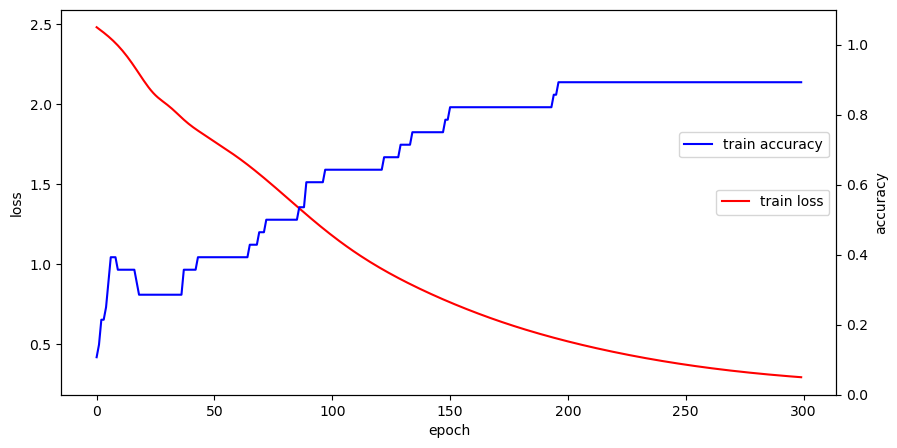

In [57]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
acc_ax.set_ylim(0.0,1.1)
plt.show()

# 4 다음 문맥 예측해 보기

In [59]:
print(t.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [67]:
# 모델 사용하기 (문자 -> sequence로 수정 -> predict -> argmax -> 문자)

word = input('입력단어 :')
encoded = t.texts_to_sequences([word])[0]

input_data = pad_sequences([encoded],
                           maxlen=X.shape[1],
                          padding='pre')
# print(f'입력한 단어 : {word}, input_data: {input_data}')
pred = model.predict(input_data, verbose=0).argmax()
for word, value in t.word_index.items():
    if pred==value:
        print('예측된 단어 :', word)
        break

입력단어 :있는
예측된 단어 : 말이


In [89]:
# 단어(가는), 5 => 가는 말이 고와야 오는 말이 곱다
def sentence_generation(model, t, current_word, n):
    for i in range(n): # n번 반복
        # current_word -> sequence -> padding -> predict.argmax -> 결과 단어(result)
        # current_word = current_word + ' ' + result
        encoded = t.texts_to_sequences([current_word])[0]
        input_data = pad_sequences([encoded],
                                  maxlen=5,
                                  padding="pre")
        pred = model.predict(input_data,
                               verbose=0).argmax()
        for word, value in t.word_index.items():
            if pred==value:
                result = word
#                 print(f"{i+1}:{result}")
                current_word = current_word + ' ' + result
#                 print(f"{i+1}:{current_word}")
                break
    return current_word

In [97]:
# 문맥 예측해 보기
sentence_generation(model, t, "오는", 4)

'오는 말이 곱다 있다 말이'